
# Прогнозирование оттока клиентов в телекоммуникационной компании


## Описание проекта: телекоммуникации

Оператор связи хочет научиться прогнозировать отток клиентов на основе собранных персональные данные и информации об их тарифах и договорах. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

### Цели

 - Построить прогнозную модель для расчета оттока клиентов для телекоммуникационной компании.

 - Основная метрика AUC-ROC, дополнительная accuracy.

 - Пороговое значение AUC-ROC 85%.

Оператор предоставляет два основных типа услуг: 
 - Стационарную телефонную связь.
    - Возможно подключение телефонного аппарата к нескольким линиям одновременно.

 - Интернет.

    - Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).


Также доступны следующие услуги:
- Интернет-безопасность:
    - антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
    - Выделенная линия технической поддержки (TechSupport);
    - Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
    - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
    
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


## Описание данных

Данные состоят из файлов, полученных из разных источников:
 - contract_new.csv — информация о договоре;
 - personal_new.csv — персональные данные клиента;
 - internet_new.csv — информация об интернет-услугах;
 - phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План работ:

  - Закрузка и первичный анализ данных
  - Подготовка данных
    - объединение таблиц
    - анализ phik_matrix
    - заполнение пропусков
    - добавление синтетических признаков
    - разбивка данных на train и test
    - балансировка, нормализация выборки + OHE

  - Обучение моделей
    - подбор параметров методом кроссвалидации (GridSearchCV)
    - выбор лучшей модели

  - Проверка лучшей модели
    - расчет целевых метрик на тестовой выборке
    - проверка на состоятельность (сравнение лучшей модели с константной моделью)

  - Выводы

## Подключение библиотек и заведение констант

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from colorama import Fore
import phik


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier

import shap
from imblearn.over_sampling import SMOTE

RS = 40823

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Загрузка и первичный анализ данных

In [2]:
# функция загружает данные и выводит общую информацию о наборе данных

def load_csv(name):
    try: df = pd.read_csv('/Users/dmitry/Desktop/yandex_python/14. Проект/' + name)
    except: df = pd.read_csv('/datasets/' + name)
    
    #общие характеристики
    print(Fore.BLUE + 'name: ', name)
    print(Fore.BLACK + 'shape: ', df.shape)
    print('кол-во дубликатов = ', df['customerID'].duplicated().sum(), '\n')
    print(df.info())
    display(df.head(5))
    print('____________________________________________________________________\n')
    
    return df


In [3]:
# загрузка данных + анализ общей информации

contract = load_csv('contract_new.csv')
personal = load_csv('personal_new.csv')
internet = load_csv('internet_new.csv')
phone = load_csv('phone_new.csv')


name:  contract_new.csv
shape:  (7043, 8)
кол-во дубликатов =  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


____________________________________________________________________

name:  personal_new.csv
shape:  (7043, 5)
кол-во дубликатов =  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


____________________________________________________________________

name:  internet_new.csv
shape:  (5517, 8)
кол-во дубликатов =  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


____________________________________________________________________

name:  phone_new.csv
shape:  (6361, 2)
кол-во дубликатов =  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


____________________________________________________________________



In [4]:
# Изменим тип данных
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], errors='coerce')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

#contract = contract.astype({'TotalCharges': float})
#contract['TotalCharges'] = contract['TotalCharges'].apply(pd.to_numeric)

print(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB
None


Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [5]:
print('доля ушедших клиентов =',
      round(100 * (1 - contract['EndDate'].isna().sum()/ len(contract)),2), '%')

доля ушедших клиентов = 15.63 %


Посмотрим на распределения величин:

In [6]:
# нахождение отношения двух гистограмм 

def share_hist(data1, data2, bins, area_min, area_max):
    
    share = []
    y1 = []
    y2 = []
    x = []
    step = ((area_max - area_min)/bins)
    
    for ix in np.arange(area_min, area_max, step):
        x.append(ix+step/2)
        res1 = 0
        res2 = 0
        for iy1 in data1:
            if (iy1 >= ix) & (iy1 < ix + step):
                res1 += 1
        for iy2 in data2:
            if (iy2 >= ix) & (iy2 < ix + step):
                res2 += 1
        
        if res1+res2>0: share.append(res1/(res1 + res2))
        else: share.append(np.NaN)
            
    return(x, share)


рассмотрим распределение разницы времен между 'EndDate' и 'BeginDate' для двух групп клиентов: кто остался и кто ушел

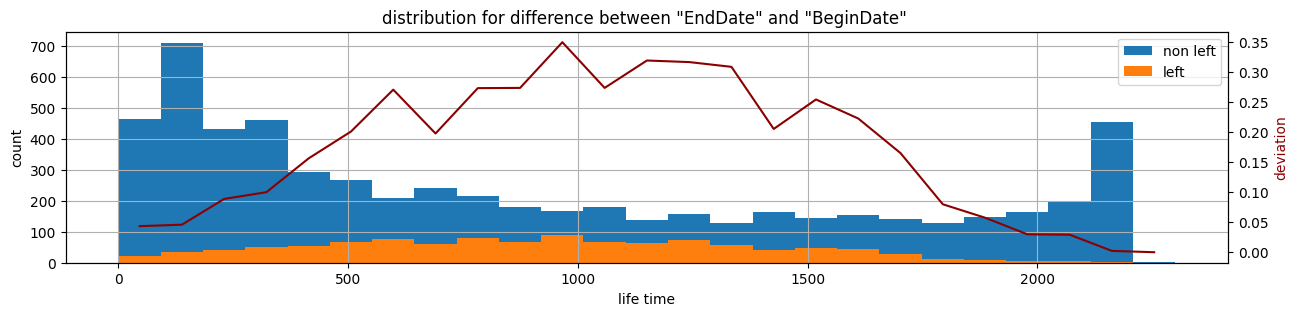

In [7]:
#подготовка данных
life_time = contract[['BeginDate', 'EndDate']].copy()
life_time['EndDate_new'] = pd.to_datetime(life_time['EndDate'].fillna('2020-02-01'))
life_time['contract_duration'] = life_time['EndDate_new'] - life_time['BeginDate']
life_time['contract_duration']=life_time['contract_duration'].dt.days

non_left = life_time.loc[life_time['EndDate'].isna() == True]['contract_duration']
left = life_time.loc[life_time['EndDate'].isna() == False]['contract_duration']

#display(life_time.head())

x_dev,y_dev = share_hist(life_time.loc[life_time['EndDate'].isna() == False]['contract_duration'],
           life_time.loc[life_time['EndDate'].isna() == True]['contract_duration'],
           25, 0, 2300)

#построение графика
fig, ax1 = plt.subplots(figsize=(15, 3))
ax2 = ax1.twinx()
ax1.hist(non_left, bins = 25, range = (0,2300), label= 'non left')
ax1.hist(left, bins = 25, range = (0,2300), label= 'left')
ax2.plot(x_dev, y_dev, color='darkred')

ax1.grid()
ax1.set_ylabel('count')
ax2.set_ylabel('deviation', color='darkred')
ax1.set_xlabel('life time')
ax1.set_title('distribution for difference between "EndDate" and "BeginDate" ')
ax1.legend()
plt.show()

рассмотрим распределение MonthlyCharges для двух групп клиентов: кто остался и кто ушел

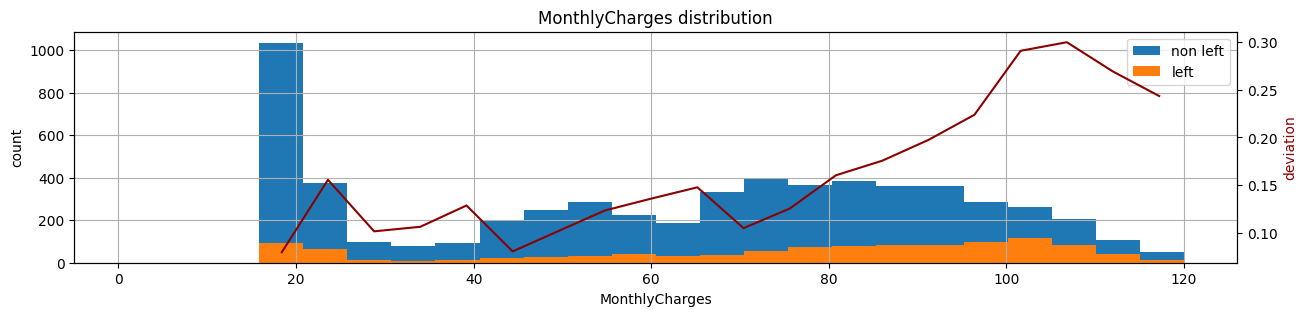

In [8]:
#подготовка данных
non_left = contract.loc[contract['EndDate'].isna() == True]['MonthlyCharges']
left = contract.loc[contract['EndDate'].isna() == False]['MonthlyCharges']

x_dev,y_dev = share_hist(contract.loc[contract['EndDate'].isna() == False]['MonthlyCharges'],
           contract.loc[contract['EndDate'].isna() == True]['MonthlyCharges'],
           25, -5, 125)
                    
#построение графика
fig, ax1 = plt.subplots(figsize=(15, 3))
ax2 = ax1.twinx()
ax1.hist(non_left, bins = 24, range = (1,120), label= 'non left')
ax1.hist(left, bins = 24, range = (1,120), label= 'left')
ax2.plot(x_dev, y_dev, color='darkred')

ax1.grid()
ax1.set_ylabel('count')
ax2.set_ylabel('deviation', color='darkred')
ax1.set_xlabel('MonthlyCharges')
ax1.set_title('MonthlyCharges distribution')
ax1.legend()
plt.show()

### Промежуточный выводы:

1. загружено 4 набора данных, содержащих информацию о клиентах и используемых ими услугах
2. отдельно каждый набор данных не водержит дубликаты и пропуски
3. целевым признаком является contract['EndDate'] - нужно будет перевести в булев тип
4. представленные данные не сбалансированны:
   - в 15,6% событий пользователь ушел
   - в 84,4% событий пользователь остался
5. был изменен тип данных для:
   - BeginDate
   - EndDate
   - TotalCharges
6. доля ушедших клиентов зависит от длительности использования сервиса. Вероятность ухода более 20% у клиентов, кто использует сервисы от ~ 500 до ~ 1600 дней
7. наблюдается рост вероятность ухода пользователя при ежемесячным платежом более ~ 80


## Подготовка данных
### Объединение таблиц

после объединения сразу удалим customerID, т.к. это идентификатор и он не может влиять на уход клиента

In [9]:
df = []
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')

df = df.drop('customerID', axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1101 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtection  5517 n

### Заполнение пропусков

После объединения таблиц возникли пропуски, которые связаны с тем, что не все клиенты пользуются сразу вдумя типами услуг.
Поэтому пропуски заполним значениями "No".

При этом в параметре TotalCharges возникли 11 пропусков после изменения формата, удалим эти строки.

In [10]:
initial_len = len(df)
df = df.loc[df['TotalCharges'].isna() == False]
final_len = len(df)

print(f'удалено {initial_len - final_len} строк или {round(100*(initial_len - final_len) / initial_len,2)}%')

df = df.fillna('No')
#df.info()

удалено 11 строк или 0.16%


### Добавление синтетических признаков

вместо EndDate сделем булеву переменную ('Lost'), которая будет показывать ушел пользователь (=1) или нет (= 0)
вместо BeginDate - ведем('Duration') разницу '2020-02-01' и BeginDate 

In [11]:
df['Lost'] = [1]*len(df)
df.loc[df['EndDate'] != 'No', 'Lost'] = 1
df.loc[df['EndDate'] == 'No', 'Lost'] = 0

df.loc[df['EndDate'] == 'No','EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['Duration'] = (df['EndDate'] - df['BeginDate']).dt.days

In [12]:
try: df = df.drop(['BeginDate', 'EndDate'], axis = 1)
except: print('параметры "BeginDate" и "EndDate" отсутствуют в выборке')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   gender            7032 non-null   object 
 6   SeniorCitizen     7032 non-null   int64  
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  MultipleLines     7032 non-null   object 
 17  

Рассмотрим какие значения встречаются в категориальных признаках и их частоту:

In [13]:
columns = ['Type', 'PaperlessBilling', 'PaymentMethod','SeniorCitizen', 'Partner', 'Dependents',
           'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies', 'MultipleLines']

columns_categories_share = []

for i in columns:
    categories = df[i].unique()
    print (i)
    category_share =[]
    for j in categories: 
        share = len(df.loc[df[i] == j][i]) / len (df)
        print(f'\t\t {int(100 * share)}% \t {j}')

Type
		 55% 	 Month-to-month
		 20% 	 One year
		 23% 	 Two year
PaperlessBilling
		 59% 	 Yes
		 40% 	 No
PaymentMethod
		 33% 	 Electronic check
		 22% 	 Mailed check
		 21% 	 Bank transfer (automatic)
		 21% 	 Credit card (automatic)
SeniorCitizen
		 83% 	 0
		 16% 	 1
Partner
		 48% 	 Yes
		 51% 	 No
Dependents
		 70% 	 No
		 29% 	 Yes
InternetService
		 34% 	 DSL
		 44% 	 Fiber optic
		 21% 	 No
OnlineSecurity
		 71% 	 No
		 28% 	 Yes
OnlineBackup
		 34% 	 Yes
		 65% 	 No
DeviceProtection
		 65% 	 No
		 34% 	 Yes
TechSupport
		 70% 	 No
		 29% 	 Yes
StreamingTV
		 61% 	 No
		 38% 	 Yes
StreamingMovies
		 61% 	 No
		 38% 	 Yes
MultipleLines
		 57% 	 No
		 42% 	 Yes


### Анализ phik_matrix

In [14]:
phik_m = round(df.phik_matrix(interval_cols = ['MonthlyCharges',
                                               'TotalCharges',
                                               'Duration']),2)

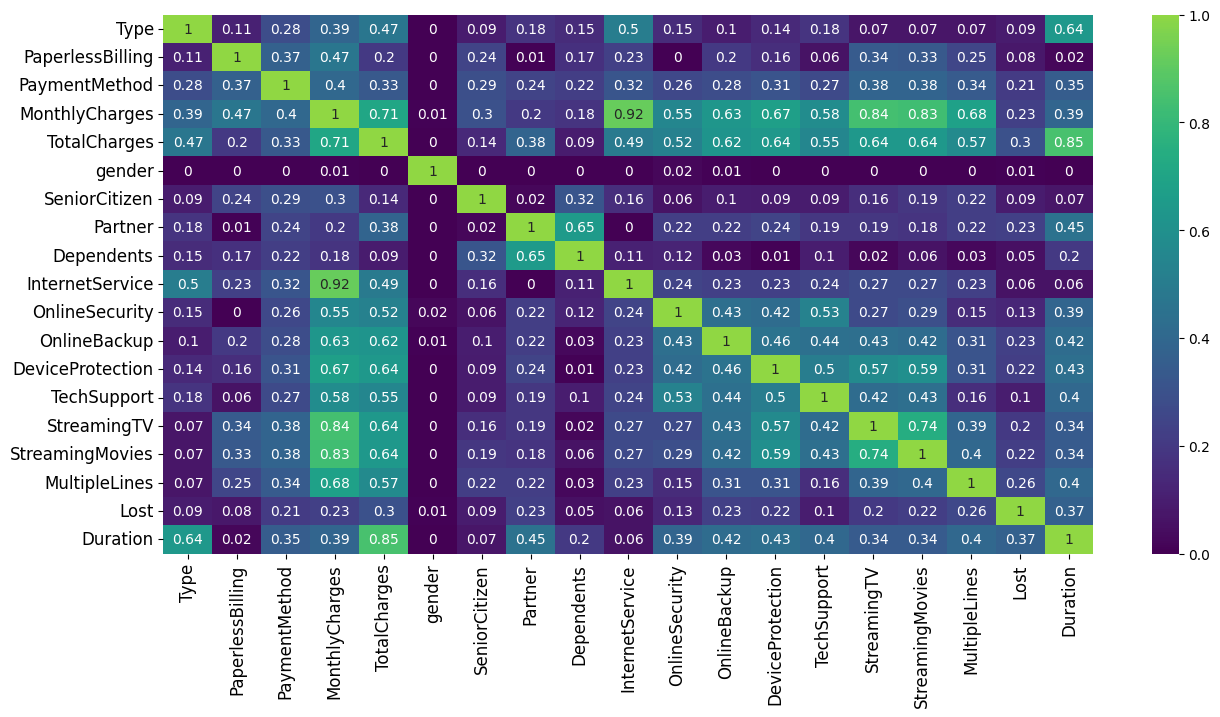

In [15]:
plt.figure(figsize=(15,7))
sns.heatmap(phik_m,
            xticklabels=phik_m.columns,
            yticklabels=phik_m.columns,
            cmap='viridis',
            center=0.6,
            annot=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Высокую (>80%) корреляцию имеют:
 - MonthlyCharges c InternetService
 - MonthlyCharges c StreamingTV
 - MonthlyCharges c StreamingMovies

Низкую корреляцию (до 2%) со всеми параметрами имеет:
 - gender

Удалим MonthlyCharges и gender

In [16]:
try: df = df.drop(['MonthlyCharges', 'TotalCharges','gender'], axis = 1)
except: print('параметры "MonthlyCharges" и "gender" отсутствуют в выборке')
#df.info()

проверим, что мультиколлинеарность устранена

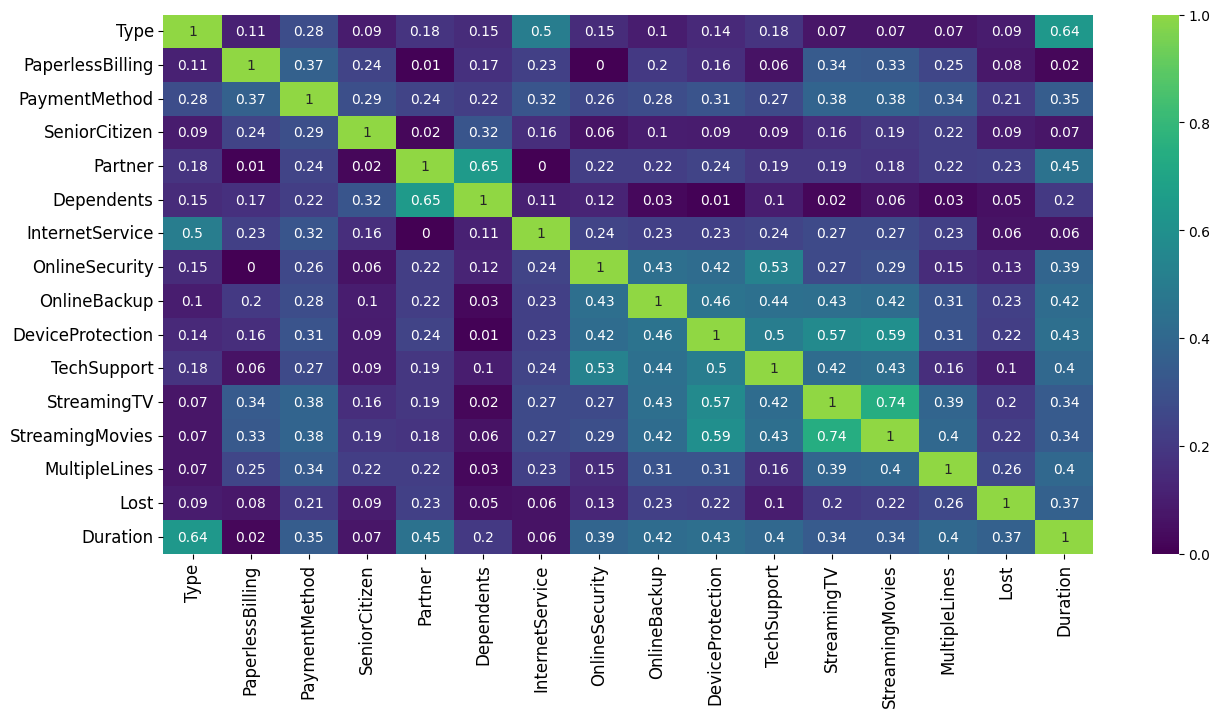

In [17]:
phik_m = round(df.phik_matrix(interval_cols = ['MonthlyCharges', 'TotalCharges', 'Duration']),2)

plt.figure(figsize=(15,7))
sns.heatmap(phik_m,
            xticklabels=phik_m.columns,
            yticklabels=phik_m.columns,
            cmap='viridis',
            center=0.6,
            annot=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Разбивка данных на train и test , балансировка тренировочной выборки

### Формирование тестовой и тренировочной выборке, OHE, SMOTE

разделим на выборку на train и test

In [18]:
train, test = train_test_split(df,test_size = 0.25,random_state = RS)
f_train = train.drop('Lost', axis=1)
f_test = test.drop('Lost', axis=1)

t_train = train['Lost']
t_test = test['Lost']

применим OHE к тренировочной выборке

In [19]:
ohe_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Partner', 'Dependents', 'InternetService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                'StreamingMovies', 'MultipleLines']

ohe_encoder = OneHotEncoder(drop='first', sparse_output = False, handle_unknown = 'ignore')

data = ohe_encoder.fit_transform(f_train[ohe_features]) # обучили энкодер
columns = ohe_encoder.get_feature_names_out()

f_train_temp = pd.DataFrame(data = data, columns = columns, index = f_train.index) # энкодер применили к train
f_train = f_train.merge(f_train_temp, on = f_train_temp.index, how = 'left') # объединили датафреймы


f_train = f_train.set_index('key_0') # установили индекс
f_train.drop(ohe_features, axis=1, inplace=True) # удалили старые признаки


применим OHE к тестовой выборке

In [20]:
#форматируем тестовую выборки
data = ohe_encoder.transform(f_test[ohe_features]) # обученный энкодер применили к test
f_test_temp = pd.DataFrame(data = data, columns = columns, index = f_test.index)
f_test = f_test.merge(f_test_temp, on = f_test_temp.index, how = 'left')

f_test = f_test.set_index('key_0')
f_test.drop(ohe_features, axis=1, inplace=True)

### Нормализация выборки

In [21]:
col = ['Duration']

scaler = StandardScaler()
scaler.fit(f_train[col])

f_train[col] = scaler.transform(f_train[col])
f_test[col]  = scaler.transform(f_test[col])

## Обучение моделей
### Подбор параметров методом кроссвалидации (GridSearchCV)


In [22]:
def roc_auc_curve (model, feutures, target, type = '-'):

    probabilities = model.predict_proba(feutures)
    probabilities_1 = probabilities[:, 1]

    fpr, tpr, thresholds = roc_curve(target, probabilities_1) 

    plt.figure(figsize = (5,3))
    plt.plot(fpr, tpr, type)
    plt.grid(True)
    plt.plot([0,1], [0,1])
    plt.title('roc_curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(['roc_curve', 'lin 0-1'])
    plt.show()

In [23]:
def roc_auc (model, feutures, target):
    
    probabilities = model.predict_proba(feutures)
    probabilities_1 = probabilities[:, 1]

    auc_roc = round(roc_auc_score(target, probabilities_1),5)
    print('auc_roc_score =\t', auc_roc)
    
    return (auc_roc)

### LogisticRegression

In [24]:
grid_space = {'C': [500, 1000, 2000, 4000, 8000]}

grid = GridSearchCV(LogisticRegression(solver = 'liblinear', random_state = RS),
                    param_grid=grid_space,
                    cv=3,
                    scoring='roc_auc',
                    n_jobs= 6
                   )

model_lr = grid.fit(f_train, t_train)
print('Параметры:')
display(model_lr.best_params_)

print(f'roc_auc= \t {round(model_lr.best_score_,5)}')
print('accuracy = \t', round(accuracy_score(t_train, model_lr.predict(f_train)),5))


Параметры:


{'C': 4000}

roc_auc= 	 0.75811
accuracy = 	 0.8614


### RandomForestClassifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

grid_space = {
              'n_estimators':[5, 10, 20, 50],
              'max_depth':[5, 10],
             }

grid = GridSearchCV(RandomForestClassifier(random_state = RS),
                    param_grid=grid_space,
                    cv=5,
                    scoring = 'roc_auc',
                    n_jobs= 6)

model_rf = grid.fit(f_train, t_train)
print('Параметры:')
display(model_rf.best_params_)

print(f'roc_auc = \t {round((model_rf.best_score_),5)}')
print('accuracy = \t', round(accuracy_score(t_train, model_rf.predict(f_train)),5))


Параметры:


{'max_depth': 5, 'n_estimators': 50}

roc_auc = 	 0.82454
accuracy = 	 0.84187


### LGBMClassifier

In [26]:
grid_space = {'n_estimators': [20,50,100,300,500],
              'max_depth' : [5,10],
              'num_leaves': [5,10,20],
              'learning_rate': [0.1,0.2,0.3, 0.5]}

grid = GridSearchCV(estimator=lgb.LGBMClassifier(random_state = RS),
                    param_grid=grid_space,
                    cv=5,
                    scoring='roc_auc',
                    n_jobs = 6 )

model_lgb = grid.fit(f_train, t_train)
print('Параметры:')
display(model_lgb.best_params_)

print(f'roc_auc = \t{round((model_lgb.best_score_),5)}')
print('accuracy = \t', round(accuracy_score(t_train, model_lgb.predict(f_train)),5))


Параметры:


{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 5}

roc_auc = 	0.9239
accuracy = 	 0.96037


### Выбор лучшей модели

In [27]:
matrix_result = pd.DataFrame(data = [[model_lr.best_score_, accuracy_score(t_train, model_lr.predict(f_train))],
                                     [model_rf.best_score_, accuracy_score(t_train, model_rf.predict(f_train))],
                                     [model_lgb.best_score_, accuracy_score(t_train, model_lgb.predict(f_train))]],
                     columns = ['roc_auc', 'accuracy'],
                     index = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier'])

matrix_result = round(matrix_result,3)
display(matrix_result)

,roc_auc,accuracy
LogisticRegression,0.758,0.861
RandomForestClassifier,0.825,0.842
LGBMClassifier,0.924,0.960


С т.з roc_auc и accuracy, полученных методом кроссвалидации на тренировочной выборке, лучшей моделью является LGBMClassifier.

Посмотри основные параметры, влияющие на результат модели.

In [28]:
explainer = shap.Explainer(model_lgb.predict, f_train)
shap_values = explainer(f_train)

Permutation explainer: 5275it [10:02,  8.65it/s]                                


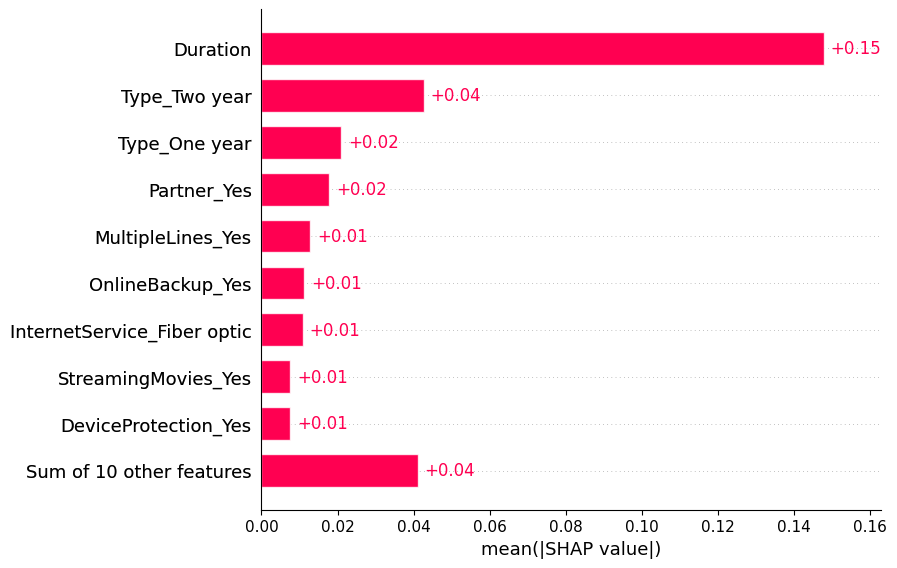

In [29]:
shap.plots.bar(shap_values)

### Проверка на состоятельность (сравнение лучшей модели с константной моделью)

roc-curve в случае с константной моделью будет состоять только из двух точек (0,0) (1,1) и формальное значение roc-auc составит 0.5.
Поэтому, с формальной точки зрения, любая не константная модель будет лучше константной модели по метрике roc-auc.

Поэтому для оценки состоятельности модели обратимся к вспомогательной метрике accuracy.

In [30]:
dm = DummyClassifier(strategy = 'constant', constant = 1)
dm.fit(f_train, t_train)

print('accuracy =', round(accuracy_score (t_train, dm.predict(f_train)),5))


accuracy = 0.15813


Значение accuracy для всех трех используемых моделей в работе больше, чем для константной модели.

Поэтому модель LGBMClassifier состоятельна.

## Проверка лучшей модели
### Расчет целевых метрик на тестовой выборке

accuracy = 	 0.941
auc_roc_score =	 0.92436


confusion matrix


,pred_0,pred_1
true_0,1482,9
true_1,95,172


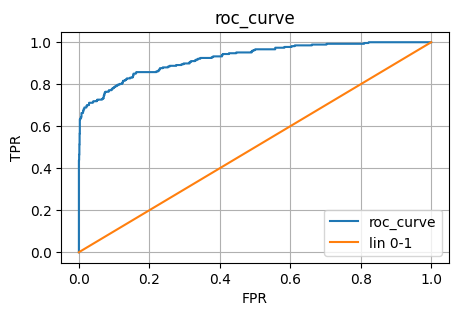

In [31]:
#Обучим модель LGBMClassifier на всей тренировочной выборке
learning_rate = model_lgb.best_params_['learning_rate']
max_depth = model_lgb.best_params_['max_depth']
n_estimators = model_lgb.best_params_['n_estimators']
num_leaves = model_lgb.best_params_['num_leaves']

best_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                    max_depth=max_depth,
                                    n_estimators=n_estimators,
                                    num_leaves=num_leaves,
                                    n_jobs =6,
                                    random_state = RS)

best_lgb.fit(f_train, t_train)

#рассчитаем метрики на тестовой выборке

print('accuracy = \t', round(accuracy_score(t_test, best_lgb.predict(f_test)),3))
roc_auc (model_lgb, f_test, t_test)

print('\n\nconfusion matrix')
conf_matrix = pd.DataFrame(data = confusion_matrix(t_test, best_lgb.predict(f_test)),
                           columns = ['pred_0', 'pred_1'],
                           index = ['true_0', 'true_1'])
display(conf_matrix)

roc_auc_curve (best_lgb, f_test, t_test)

## Выводы

Целью работы является - построение предсказательной модели оотока клиентов. Основаная метрика - roc-auc (пороговое значение (0.85), вспомогательная метрика accuracy.

В рамках работы: 
  
1. Проведен первичный анализ данных:

2. Заполнены пропуски, скорректированы типы данных, выявлены и удалены мультиколлинеарные параметры.
    
3. Выявлены зависимости между вероятностью ухода клиента и ежемесячным платежом:
   - при ежемесячном платеже < 80 вероятность ухода пользователя составляет с 10-15%
   - при ежемесячном платеже < 95 вероятность ухода пользователя возрастает до 25%
   - при ежемесячном платеже > 95 вероятность ухода пользователя составляет с 25-32%

   Выявлены зависимости между вероятностью ухода клиента и временем нахождения в компании. Можно выделить три группы клиентов:
   - новые клиенты (используют сервисы не более 400 дней) вероятность ухода менее 15%
   - высокорисковые клиенты (используют сервисыот 400 до 1700 дней) вероятность ухода от 15% до 35%
   - лояльные клиенты (используют сервисы более 1700 дней) вероятность ухода менее 15%

   Выявлены зависимости между вероятностью ухода клиента и количеством дней существовария когорты:
   - наблюдается ~ линейный рост вероятности ухода на всем промежутке от 0 до 2300 дней. Вероятность уходя возрастает от 0% до 35-40%
        
5. Добавлены синтетические параметры, проведено кодирование данных методом OHE, проведена нормализация  и балансировка тренировочной выборки (т.к. начальная выборка не сбалансирована) 

6. Для предсказания оттока клиентов обучены на тренировочных данных методом кросс валидиции и подобраны макропараметры для 3 моделей:
   - LogisticRegression,
   - RandomForestClassifier,
   - LGBMClassifier

   Лучшей моделью с т.з. roc-auc является LGBMClassifier. Достигнутоне значение roc-auc на сбалансированной тренировочной выборке равно 0.924, accuracy равно 0.941


8. Проведен анализ слияния параметров на целевой показатель (ушел / не ушел клиент). Топ 5 параметров:
   - Duration (как давно сформирована когорта)
   - TotalCharges (суммарные платежы за все время жизни клиента)
   - InternetServis_fiber optic (использование услуги оптоволоконного интернета)

7. Результаты проверки модели лучшей LGBMClassifier модели составили:
    - roc-auc 0.938
    - accuracy 0.925
    - в 33% случаев модель ошибочно предсказала, что пользователь останется
    - в 1 % случаев модель ошибочно предсказала, что пользователь уйдет
    
    Данный дисбаланс может оказаться существенным ввиду несбалансированности классов и необходимо его дополнительно проанализировать с точки зрения прибыльности пользователей и затрат на их удержание.

   По результатам проверки модели LGBMClassifier, можно сказать, что на тренировочных данных модель переобучилась. Что предположительно вызнавно методом нормализации данных.

   Цели работы достигнуты, значение roc-auc составило ~92%.